## Speech Emotion Detection Using LSTM

In [ ]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install pyaudio
!pip install json-tricks

In [ ]:
%%capture
import os
from json_tricks import load,dump

import numpy as np

import librosa
from pydub import AudioSegment, effects
import noisereduce as nr

import tensorflow as tf
import keras
from keras.models import model_from_json
from keras.models import load_model
import librosa

import matplotlib.pyplot as plt

## The data

## The speech emotion audio databases used:

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) https://zenodo.org/record/1188976#.X4sE0tDXKUl

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) was recorded with 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.
1440 files = 24 actors x 60 trails per actor
8 Emotions (neutral, calm, happy, sad, angry, fearful, disgust, surprised).

## Toronto Emotional Speech Set (TESS) https://tspace.library.utoronto.ca/handle/1807/24487

2800 files = 2 actors x 200 pharses x 7 emotions
7 Emotions (neutral, happiness, sadness, anger, fear, disgust, pleasant surprise)


## Preprocessing

In [ ]:
def preprocess(file_path, frame_length = 2048, hop_length = 512):
    '''
    A process to an audio .wav file before execcuting a prediction.
      Arguments:
      - file_path - The system path to the audio file.
      - frame_length - Length of the frame over which to compute the speech features. default: 2048
      - hop_length - Number of samples to advance for each frame. default: 512

      Return:
        'X_3D' variable, containing a shape of: (batch, timesteps, feature) for a single file (batch = 1).
    ''' 
    # Fetch sample rate.
    _, sr = librosa.load(path = file_path, sr = None)
    # Load audio file
    rawsound = AudioSegment.from_file(file_path, duration = None) 
    # Normalize to 5 dBFS 
    normalizedsound = effects.normalize(rawsound, headroom = 5.0) 
    # Transform the audio file to np.array of samples
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32') 
    # Noise reduction                  
    final_x = nr.reduce_noise(normal_x, sr=sr, use_tensorflow=True)
        
        
    f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length, center=True, pad_mode='reflect').T # Energy - Root Mean Square
    f2 = librosa.feature.zero_crossing_rate(final_x, frame_length=frame_length, hop_length=hop_length,center=True).T # ZCR
    f3 = librosa.feature.mfcc(final_x, sr=sr, S=None, n_mfcc=13, hop_length = hop_length).T # MFCC   
    X = np.concatenate((f1, f2, f3), axis = 1)
    
    X_3D = np.expand_dims(X, axis=0)
    
    return X_3D


In [ ]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name): 
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"
        
        
# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

In [ ]:
# Maximum samples count for padding purposes.

sample_lengths = []
folder_path = '/content/drive/MyDrive/Colab Notebooks/Capstone/AudioData'

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)
     
    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))    

Maximum sample length: 204288


In [ ]:
import time
tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 204288 # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

folder_path = '/content/drive/MyDrive/Colab Notebooks/Capstone/AudioData' 

for subdir, dirs, files in os.walk(folder_path):
  for i, file in enumerate(files): 

    # Fetch the sample rate.
      _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Load the audio file.
      rawsound = AudioSegment.from_file(os.path.join(subdir,file)) 
    # Normalize the audio to +5.0 dBFS.
      normalizedsound = effects.normalize(rawsound, headroom = 0) 
    # Transform the normalized audio to np.array of samples.
      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
      xt, index = librosa.effects.trim(normal_x, top_db=30)
      #print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed-- 
    # Pad for duration equalization.
      if(len(xt)>total_length):
        print(f'index {i} ', len(xt), total_length)
        #total_length = len(xt)
      padded_x = np.pad(xt, (0, max(0, total_length-len(xt))), 'constant')
    # Noise reduction.
      final_x = nr.reduce_noise(padded_x, sr=sr) #updated 03/03/22
       
   # Features extraction 
      f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square   
      f2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR      
      f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
      
   # Emotion extraction from the different databases
      if (find_emotion_T(file) != "-1"): #TESS database validation
            name = find_emotion_T(file)
      else:                              #RAVDESS database validation
            name = file[6:8]                      

   # Filling the data lists  
      rms.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
      emotions.append(emotionfix(name)) 

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

index 42  205824 204288
index 15  228864 204288
Running time: 13.2871 minutes


In [ ]:
rms_new = np.array([x for i, x in enumerate(rms) if x.shape == tuple([1, 400])])
zrc_new = np.array([x for i, x in enumerate(zcr) if x.shape == tuple([1, 400])])
mfcc_new = np.array([x for i, x in enumerate(mfcc) if x.shape == tuple([13, 400])])



In [ ]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)

f_rms = np.array(rms_new).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zrc_new).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc_new).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (4238, 400, 1)
RMS shape: (4238, 400, 1)
MFCCs shape: (4238, 400, 13)


In [ ]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.array([x for i, x in enumerate(emotions) if i not in [582, 615]]).astype('int8')
Y = np.expand_dims(Y, axis=1)

In [ ]:
np.unique(Y)
x_data = X.tolist() 

x_path = '/content/drive/MyDrive/Colab Notebooks/Capstone/new model/new/X_datanew.json' # FILE SAVE PATH


In [ ]:
dump( x_data,x_path)

In [ ]:
y_data = Y.tolist() 
y_path = '/content/drive/My Drive/Colab Notebooks/Capstone/new model/new/Y_datanew.json' # FILE SAVE PATH
dump( y_data,  y_path)

'[[0], [1], [2], [1], [3], [1], [2], [2], [1], [2], [2], [1], [0], [1], [0], [2], [1], [2], [3], [1], [3], [2], [0], [6], [7], [5], [5], [6], [3], [6], [7], [3], [6], [5], [4], [4], [7], [5], [7], [6], [7], [5], [6], [4], [5], [7], [4], [3], [4], [3], [6], [5], [4], [4], [4], [5], [6], [7], [7], [3], [1], [1], [0], [0], [1], [1], [0], [1], [1], [1], [0], [4], [3], [5], [7], [7], [5], [6], [3], [6], [1], [5], [5], [4], [2], [3], [2], [3], [2], [2], [6], [6], [2], [6], [6], [4], [4], [3], [6], [4], [4], [7], [3], [2], [5], [6], [2], [3], [5], [5], [2], [7], [4], [4], [3], [5], [7], [7], [7], [7], [5], [4], [4], [1], [0], [4], [5], [5], [2], [3], [4], [1], [2], [1], [2], [3], [3], [0], [5], [3], [1], [4], [2], [4], [2], [4], [1], [4], [2], [1], [0], [1], [0], [3], [3], [3], [2], [1], [5], [3], [2], [5], [6], [7], [6], [6], [7], [5], [6], [7], [7], [5], [7], [6], [7], [6], [6], [6], [7], [7], [2], [1], [2], [1], [3], [2], [2], [2], [1], [0], [3], [1], [0], [3], [1], [1], [3], [3], [1], [0]

In [ ]:
x_path = '/content/drive/MyDrive/Colab Notebooks/Capstone/new model/new/X_datanew.json' # FILE LOAD PATH
X1 = load(x_path)


In [ ]:
# Load X,Y json files back into lists, convert to np.arrays


X = np.asarray(X, dtype = 'float32')

#y_path = '/content/drive/MyDrive/Colab Notebooks/Capstone/new model/new/Y_datanew.json' # FILE LOAD PATH
Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')

In [ ]:
X = x_data
Y=y_data
print(type(Y))

<class 'list'>


In [ ]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 45)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 45)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 8, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 8, dtype = 'int8')

In [ ]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train[1:3]))
print(np.shape(x_val))
print(np.shape(x_test))

(2, 400, 15)
(368, 400, 15)
(162, 400, 15)


In [ ]:
# Save x_test, y_test to JSON.

file_path = 'x_test_data.json'
dump(x_test, file_path)

file_path = 'y_test_data.json'
dump(y_test, file_path)

'{"__ndarray__": [[2], [4], [0], [5], [6], [5], [4], [4], [6], [6], [6], [7], [5], [6], [3], [7], [1], [0], [7], [0], [5], [3], [5], [7], [3], [3], [4], [7], [3], [3], [2], [0], [3], [3], [4], [0], [0], [4], [5], [5], [2], [2], [1], [5], [7], [5], [4], [2], [3], [4], [6], [6], [3], [7], [6], [4], [3], [1], [4], [1], [3], [2], [4], [5], [0], [6], [0], [0], [4], [5], [2], [7], [3], [5], [2], [2], [7], [7], [3], [2], [4], [1], [0], [1], [7], [4], [7], [0], [4], [6], [6], [6], [2], [0], [7], [0], [3], [4], [2], [0], [6], [4], [5], [3], [3], [2], [3], [2], [5], [7], [6], [4], [7], [4], [4], [0], [2], [3], [0], [6], [6], [1], [0], [4], [6], [5], [4], [4], [7], [6], [5], [4], [2], [1], [7], [2], [2], [3], [1], [7], [7], [0], [0], [6], [3], [2], [6], [0], [2], [6], [4], [5], [6], [3], [6], [6], [0], [7], [7], [3], [6], [4]], "dtype": "int8", "shape": [162, 1], "Corder": true}'

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks
from tensorflow.keras.optimizers import Adam 

In [ ]:
# Initializing the model

model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 32

# Callbacks functions
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Capstone/new model/new/best_weights.hdf5'

#-> Save the best weights
#checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Capstone/new model/best_weightsecond.hdf5'
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=10, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=60,
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.0006), loss='categorical_crossentropy', metrics=['accuracy'])
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 400, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 54,024
Trainable params: 54,024
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 400, 64)           20480     
                                                                 
 lstm_1 (LSTM)             

In [ ]:
#!pip install livelossplot

In [ ]:
from livelossplot import PlotLossesKeras

In [ ]:

history = model.fit(x_train, y_train_class, 
                      epochs=400, batch_size = batch_size, 
                      validation_data = (x_val, y_val_class), 
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
#model.load_weights(checkpoint_path)

Epoch 1/400
116/116 [==============================] - 19s 161ms/step - loss: 1.9275 - accuracy: 0.2273 - val_loss: 1.9046 - val_accuracy: 0.2228 - lr: 6.0000e-04
Epoch 2/400
116/116 [==============================] - 19s 160ms/step - loss: 1.9237 - accuracy: 0.2362 - val_loss: 1.9024 - val_accuracy: 0.2174 - lr: 6.0000e-04
Epoch 3/400
116/116 [==============================] - 18s 159ms/step - loss: 1.9205 - accuracy: 0.2406 - val_loss: 1.9351 - val_accuracy: 0.2527 - lr: 6.0000e-04
Epoch 4/400
116/116 [==============================] - 19s 161ms/step - loss: 1.9260 - accuracy: 0.2265 - val_loss: 1.9471 - val_accuracy: 0.2201 - lr: 6.0000e-04
Epoch 5/400
116/116 [==============================] - 19s 161ms/step - loss: 1.9278 - accuracy: 0.2357 - val_loss: 1.9068 - val_accuracy: 0.2255 - lr: 6.0000e-04
Epoch 6/400
116/116 [==============================] - 19s 161ms/step - loss: 1.9271 - accuracy: 0.2360 - val_loss: 1.9606 - val_accuracy: 0.1984 - lr: 6.0000e-04
Epoch 7/400
116/116 [=

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


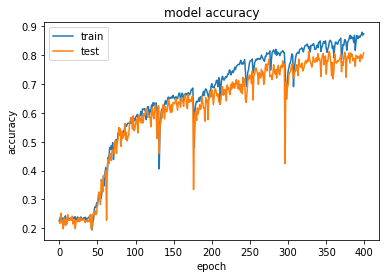

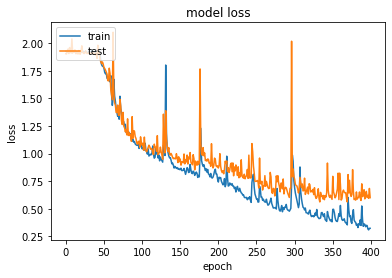

In [ ]:

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

12/12 - 1s - loss: 0.6013 - accuracy: 0.8071 - 703ms/epoch - 59ms/step


In [ ]:
thistory = model.fit(x_train, y_train, batch_size=16, epochs=500, validation_split=0.1, 
                    callbacks=[early_stop, model_checkpoint, reduce_lr])

Epoch 1/500
209/209 [==============================] - 39s 163ms/step - loss: 1.5562 - accuracy: 0.3992 - val_loss: 1.6220 - val_accuracy: 0.3396 - lr: 6.0000e-04
Epoch 2/500
209/209 [==============================] - 33s 159ms/step - loss: 1.5710 - accuracy: 0.3983 - val_loss: 1.8158 - val_accuracy: 0.2588 - lr: 6.0000e-04
Epoch 3/500
209/209 [==============================] - 33s 160ms/step - loss: 1.5522 - accuracy: 0.3968 - val_loss: 1.5511 - val_accuracy: 0.3881 - lr: 6.0000e-04
Epoch 4/500
209/209 [==============================] - 33s 159ms/step - loss: 1.5211 - accuracy: 0.4088 - val_loss: 1.6584 - val_accuracy: 0.3531 - lr: 6.0000e-04
Epoch 5/500
209/209 [==============================] - 33s 159ms/step - loss: 1.5371 - accuracy: 0.4031 - val_loss: 1.5790 - val_accuracy: 0.3854 - lr: 6.0000e-04
Epoch 6/500
209/209 [==============================] - 33s 160ms/step - loss: 1.5092 - accuracy: 0.4240 - val_loss: 1.5899 - val_accuracy: 0.4070 - lr: 6.0000e-04
Epoch 7/500
209/209 [=

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

In [ ]:
#model.save('/content/drive/MyDrive/Colab Notebooks/my_model')


In [ ]:
import pandas as pd

Text(0.5, 51.0, 'Predicted emotion')

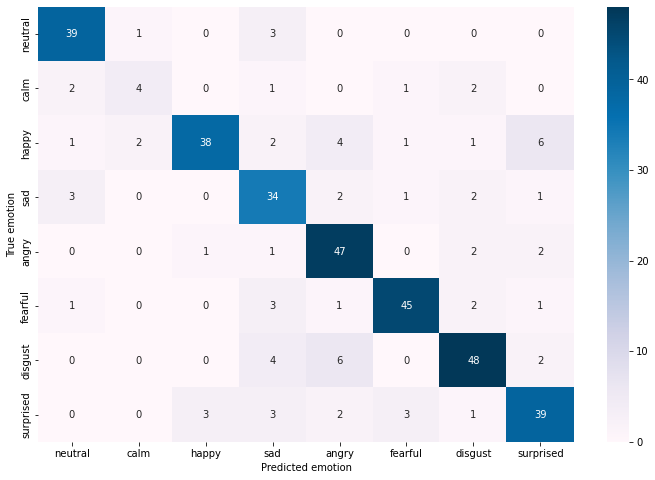

In [ ]:
# Validation Confusion matrix

#y_val_class = np.argmax(y_val_class, axis=1)
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_val_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [ ]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum
lst = []
print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")
    lst.append(acc[e])

Validation set predicted emotions accuracy:
neutral : 0.9070
calm : 0.4000
happy : 0.6909
sad : 0.7907
angry : 0.8868
fearful : 0.8491
disgust : 0.8000
surprised : 0.7647
